In [162]:
#imports and device setting
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

#device agnostic code:
if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
else:
    device="cpu"

In [163]:
#create a linear regression dataset
weight = 0.3
bias = 0.9

X_data = torch.arange(start=0,end=100,step=1,dtype=torch.float).unsqueeze(dim=1)
Y_labels = weight * X_data + bias

In [164]:
# 80 20 split the training and testing data
train_test_split = (0.8,0.2)
split_index = int(len(X_data) * train_test_split[0])
X_train, X_test = X_data[:split_index], X_data[split_index:]
Y_train, Y_test = Y_labels[:split_index], Y_labels[split_index:]
len(X_train), len(X_test), len(Y_train), len(Y_test)

(80, 20, 80, 20)

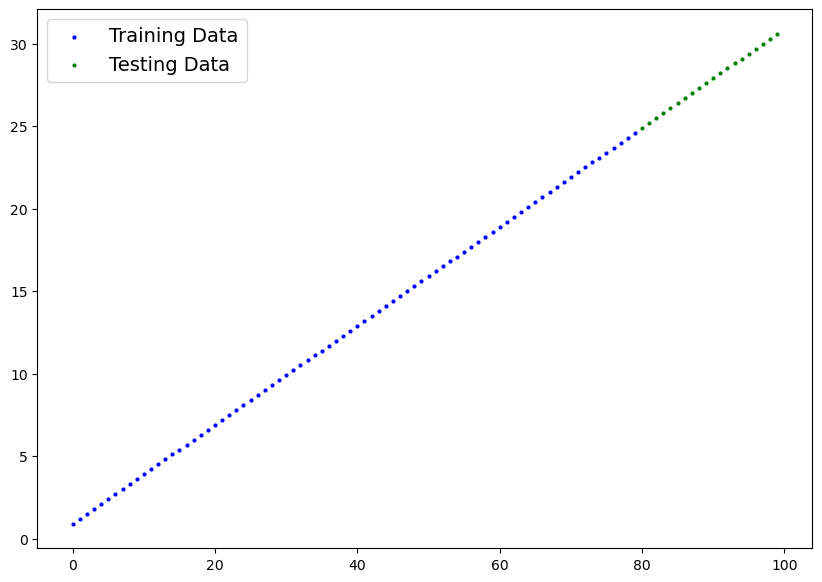

In [165]:
#plotting the data with a function:
def plot_predictions(training_features=X_train, training_labels=Y_train,testing_features=X_test,
                      testing_labels=Y_test, predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(training_features, training_labels, c="b", s=4, label="Training Data")
    plt.scatter(testing_features, testing_labels, c="g", s=4, label="Testing Data")
    if predictions is not None:
        plt.scatter(testing_features, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size":14})
plot_predictions()

In [166]:
#Now, build a pytorch model by subclassing nn.Module that has a linear layer to predict
torch.manual_seed(42)
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
model = LinearRegressionModel()
model.to(device)
print(f"Current randomized tensor statedict is : {model.state_dict()}")

Current randomized tensor statedict is : OrderedDict({'linear_layer.weight': tensor([[0.7645]], device='mps:0'), 'linear_layer.bias': tensor([0.8300], device='mps:0')})


In [167]:
#loss function and optimizer
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.0001)

In [168]:
#train test loop, test every 20 epochs
epochs = 300
training_loss_values=[]
testing_loss_values=[]
number_of_epochs=[]

#actually, we should first move the data to the gpu
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)


for epoch in range(epochs):

    #first you do a forward pass with the data
    model.train()
    y_preds = model(X_train)

    #now, calculate the loss
    loss = loss_fn(y_preds,Y_train)

    #now zero the gradients
    optimizer.zero_grad()

    #now do a backward pass to clacualte gradients
    loss.backward()

    #now step the optimizer to correct the parameters to minimize the loss
    optimizer.step()

    #Now, the testing loop
    if epoch % 5 == 0:
        model.eval()
        with torch.inference_mode():
            test_preds = model(X_test)

            test_loss = loss_fn(test_preds,Y_test)

            training_loss_values.append(loss.detach().cpu().numpy())
            testing_loss_values.append(test_loss.detach().cpu().numpy())
            number_of_epochs.append(epoch)
            print(f"Epoch: {epoch} | MAE Training Loss: {loss} | MAE Testing Loss: {test_loss}")
    


Epoch: 0 | MAE Training Loss: 18.281030654907227 | MAE Testing Loss: 41.152584075927734
Epoch: 5 | MAE Training Loss: 17.500431060791016 | MAE Testing Loss: 39.38447189331055
Epoch: 10 | MAE Training Loss: 16.719829559326172 | MAE Testing Loss: 37.61635971069336
Epoch: 15 | MAE Training Loss: 15.939227104187012 | MAE Testing Loss: 35.84824752807617
Epoch: 20 | MAE Training Loss: 15.1586275100708 | MAE Testing Loss: 34.080135345458984
Epoch: 25 | MAE Training Loss: 14.378028869628906 | MAE Testing Loss: 32.31201934814453
Epoch: 30 | MAE Training Loss: 13.597427368164062 | MAE Testing Loss: 30.543909072875977
Epoch: 35 | MAE Training Loss: 12.816827774047852 | MAE Testing Loss: 28.775793075561523
Epoch: 40 | MAE Training Loss: 12.036226272583008 | MAE Testing Loss: 27.0076847076416
Epoch: 45 | MAE Training Loss: 11.25562572479248 | MAE Testing Loss: 25.239572525024414
Epoch: 50 | MAE Training Loss: 10.475025177001953 | MAE Testing Loss: 23.471458435058594
Epoch: 55 | MAE Training Loss: 9

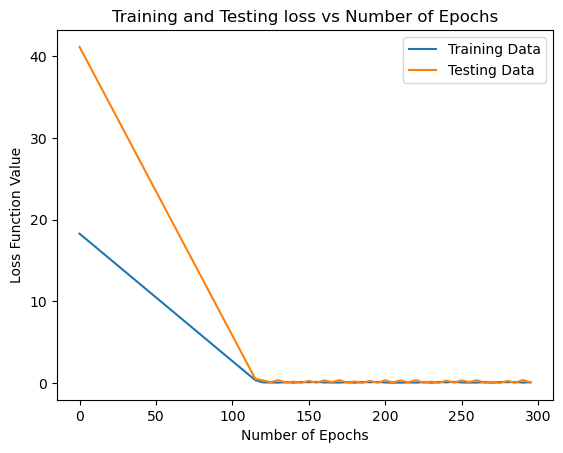

In [169]:
#graph training/testing loss vs epochs

plt.plot(number_of_epochs,training_loss_values,label="Training Data")
plt.plot(number_of_epochs, testing_loss_values, label="Testing Data")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Value")
plt.title("Training and Testing loss vs Number of Epochs")
plt.legend()

The models predicted values for the parameters were: OrderedDict({'linear_layer.weight': tensor([[0.3011]], device='mps:0'), 'linear_layer.bias': tensor([0.8229], device='mps:0')})


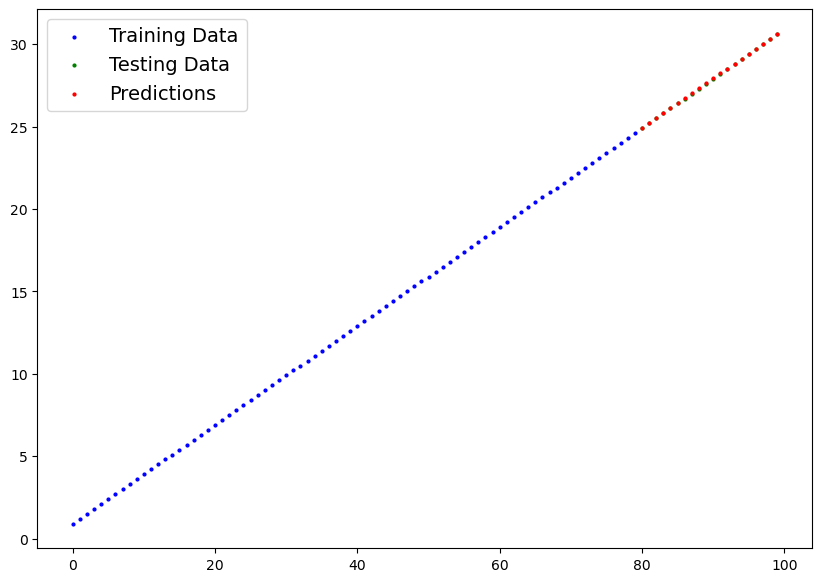

In [170]:
#now, lets do an inference test on teh test data with our trained model:
model.eval()

with torch.inference_mode():
    final_preds = model(X_test)

plot_predictions(predictions=final_preds.cpu())

print(f"The models predicted values for the parameters were: {model.state_dict()}")


In [171]:
#Now, time to save the model's state dict
from pathlib import Path

MODEL_PATH = Path("models") #creates a path variable that hold the path to a model directory that doesn't have to exist yet
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#now make the file 
MODEL_NAME = "Unit_1_HW_Linear_model"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Now time to save the state_dict:
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


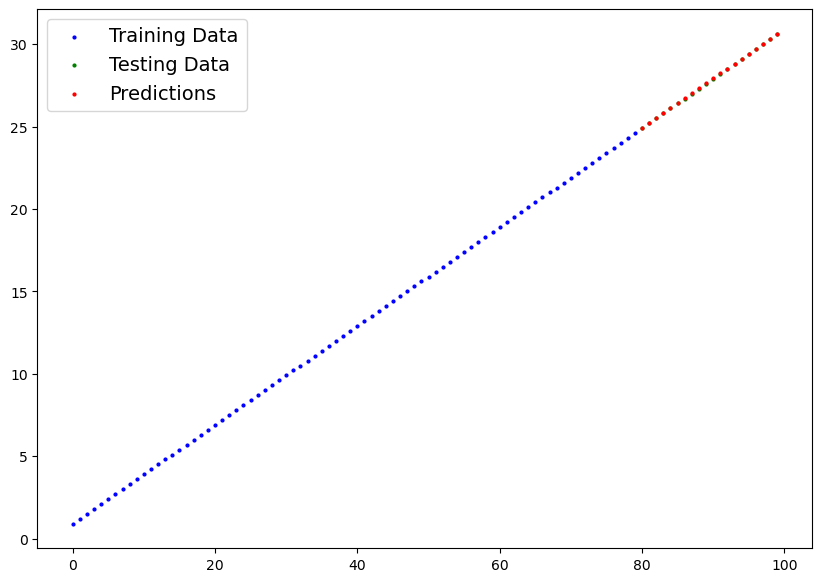

In [172]:
# now load the model and do inference on it again

model_loaded = LinearRegressionModel()
model_loaded.to(device) #REMEMBER, BY DEFAULT BOTH THE MODEL AND ALL TENSORS ARE ON THE CPU!!!
model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

#now try inference with the loaded model:
model_loaded.eval()
with torch.inference_mode():
    loaded_predicts = model_loaded(X_test)
plot_predictions(predictions=loaded_predicts.cpu())